Step 1: Data Set and Exploration

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=6c1177e178b73cbee0e8fa8a8bfa427972b71a56c3f8d00f453faec32b7eaea5
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Telecom Customer Churn Prediction") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv('/content/telecom_churn.csv', header=True, inferSchema=True)

# Show the first few rows of the dataset
df.show(5)

# Print the schema to understand the data types
df.printSchema()

# Basic statistics for numerical features
df.describe().show()

# Check for missing values in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Step 2: Data Preprocessing

In [ ]:
from pyspark.sql.functions import col, when


# Create a DataFrame with the count of nulls for each column
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Replace blank strings in 'TotalCharges' with None (null)
df = df.withColumn("TotalCharges", when(col("TotalCharges") == "", None).otherwise(col("TotalCharges")))

# Convert 'TotalCharges' to float
df = df.withColumn("TotalCharges", col("TotalCharges").cast("float"))

# # Drop any rows that now have null 'TotalCharges' if necessary or fill with median/mean
# df = df.na.fill({"TotalCharges": df.approxQuantile("TotalCharges", [0.5], 0.0)[0]})

# # Check for nulls in all columns and drop or fill
# df = df.na.drop()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [ ]:
from pyspark.sql.functions import col, mean, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

# List of categorical columns as per your dataset schema
categorical_features = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

# Identify numerical columns - assuming these are your numerical columns
numerical_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']




# Feature engineering
df = df.withColumn("AvgMonthlyCharges", col("TotalCharges") / col("tenure"))
df = df.withColumn("Internet_and_Support", (col("InternetService") != "No") & (col("TechSupport") == "Yes"))

# Fill missing values for numerical columns with their mean
mean_values = df.select([mean(c).alias(c) for c in numerical_features]).first()
means = {c: mean_values[c] for c in numerical_features}
df = df.na.fill(means)

# Fill missing values in categorical columns with "Unknown"
df = df.na.fill("Unknown", subset=categorical_features)

# Feature engineering
df = df.withColumn("AvgMonthlyCharges", col("TotalCharges") / col("tenure"))
df = df.withColumn("Internet_and_Support", (col("InternetService") != "No") & (col("TechSupport") == "Yes"))

# Indexing and encoding categorical features
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_features]
encoders = [OneHotEncoder(inputCols=[column+"_index"], outputCols=[column+"_encoded"]) for column in categorical_features]

# Assembling all features into one vector
assemblerInputs = [c + "_encoded" for c in categorical_features] + numerical_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Indexing the label column 'Churn'
labelIndexer = StringIndexer(inputCol="Churn", outputCol="indexedLabel").fit(df)
# Define the RandomForest classifier
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

# Create a Pipeline including the label indexer
pipeline = Pipeline(stages=indexers + encoders + [labelIndexer, assembler, rf])

# Split the data
(train_data, test_data) = df.randomSplit([0.6, 0.4], seed=7)

# Train the RandomForest model
model = pipeline.fit(train_data)

# Extract the RandomForest model from the pipeline
rfModel = model.stages[-1]

# Get feature importances
feature_importances = rfModel.featureImportances
importances_list = [(feature, importance) for feature, importance in zip(assemblerInputs, feature_importances)]
sorted_importances = sorted(importances_list, key=lambda x: x[1], reverse=True)

# # Print feature importances
# for feat, imp in sorted_importances:
#     print(f"Feature: {feat}, Importance: {imp}")

# Transform the entire dataset
df_transformed = model.transform(df)

# Show the transformed DataFrame
df_transformed.show()

# Optionally convert to Pandas DataFrame for further analysis or visualization
pdf_transformed = df_transformed.toPandas()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+------------------+--------------------+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+--------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+------------+--------------------+----------------

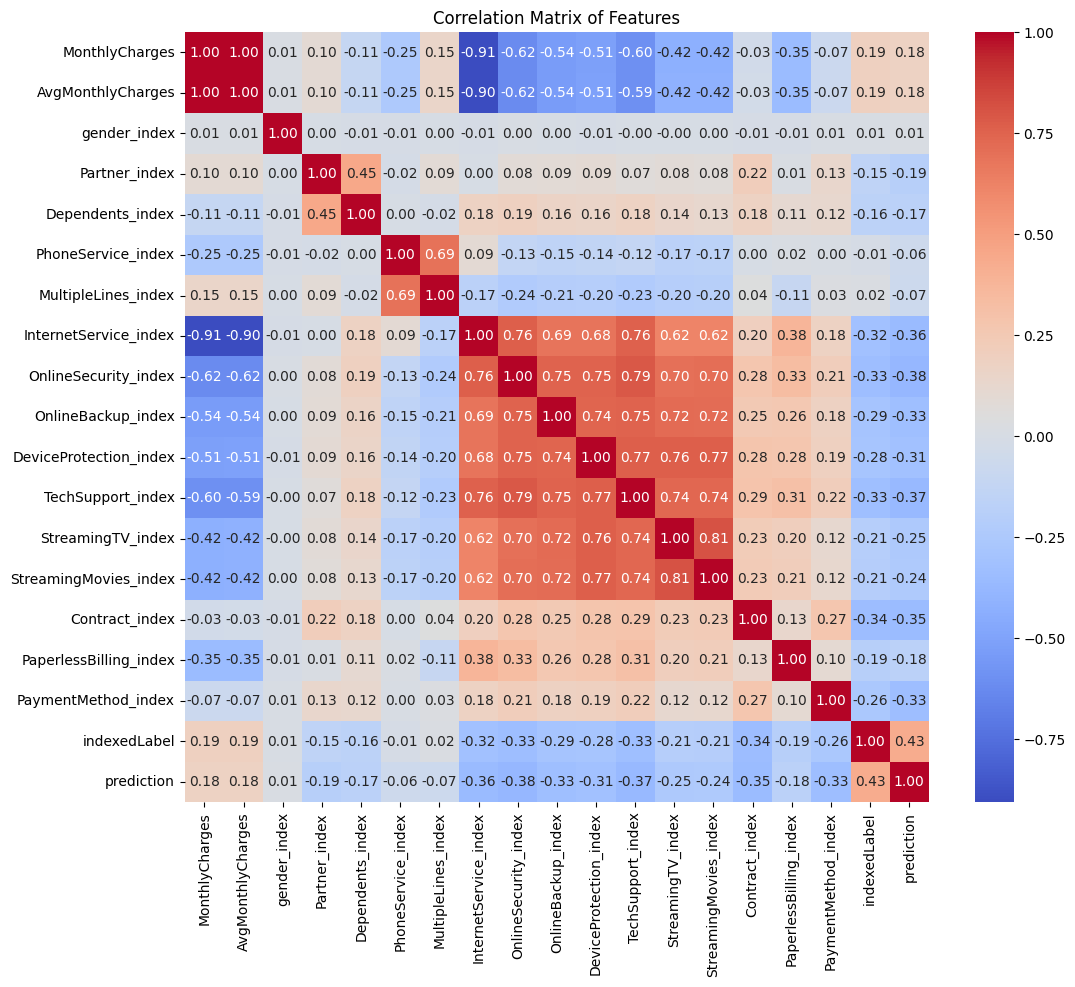

In [ ]:
# Compute the correlation matrix (consider numerical features only)
correlation_matrix = pdf_transformed.select_dtypes(include=['float64', 'int64']).corr()
# Generate a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

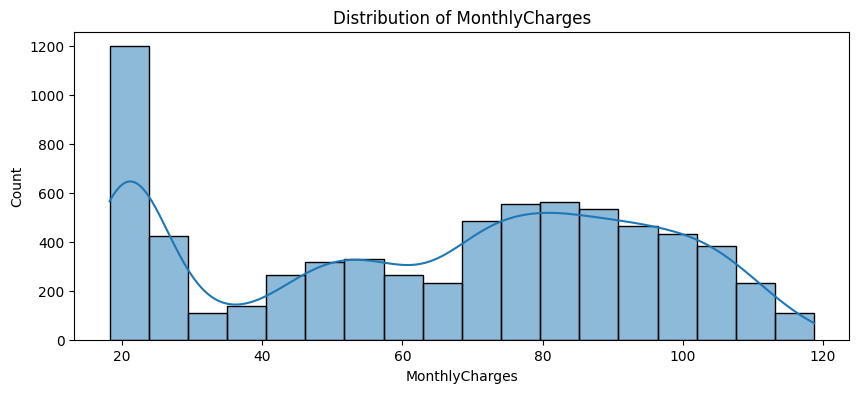

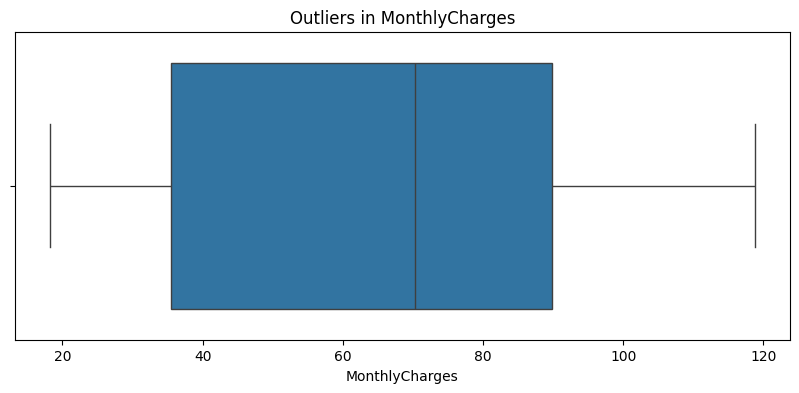

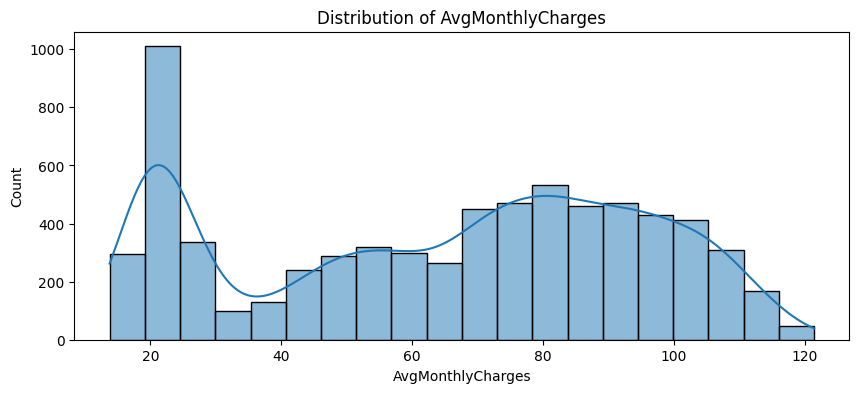

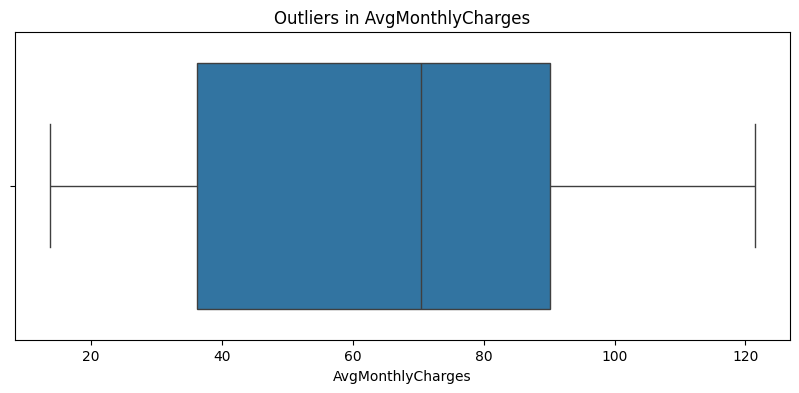

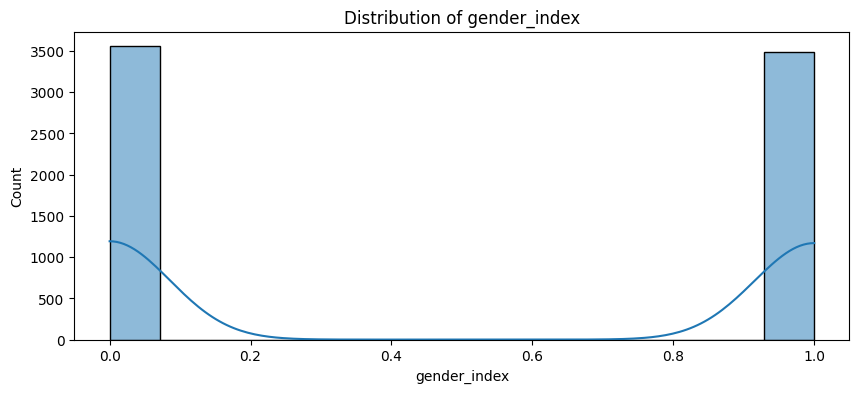

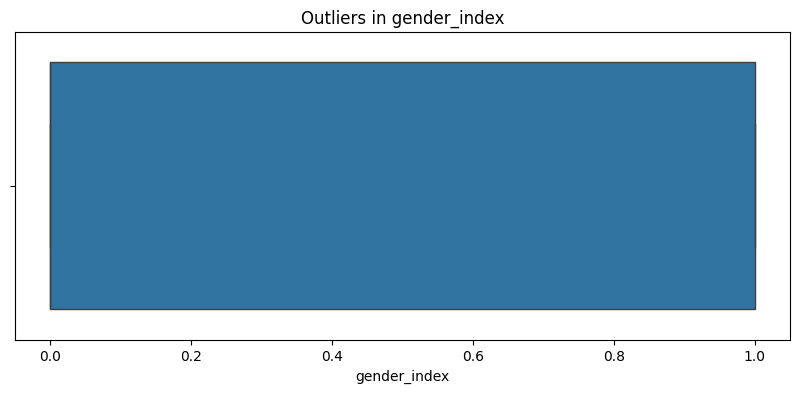

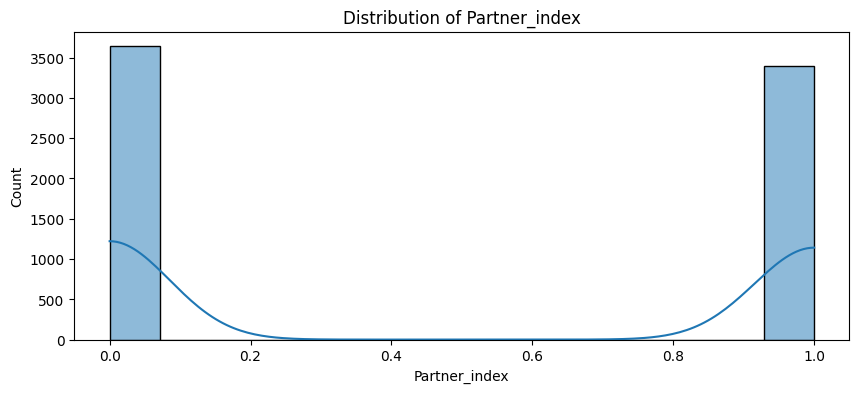

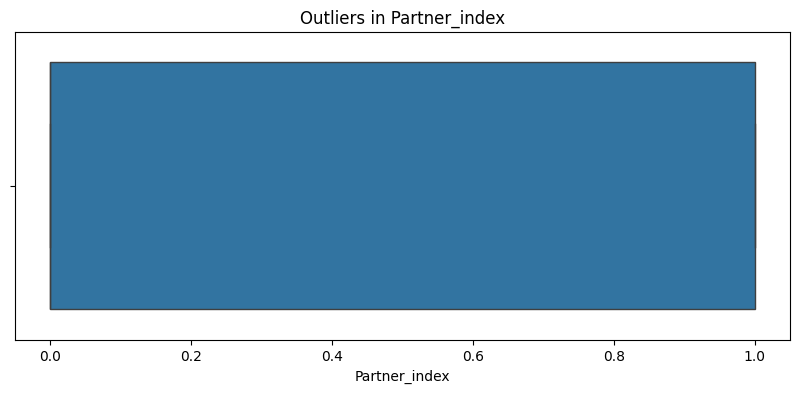

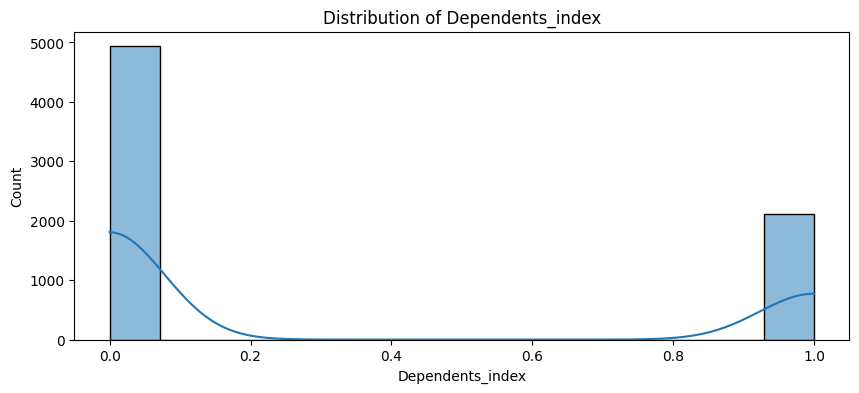

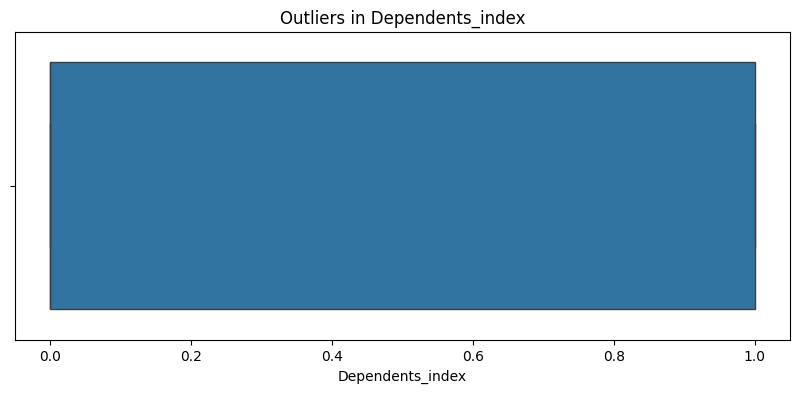

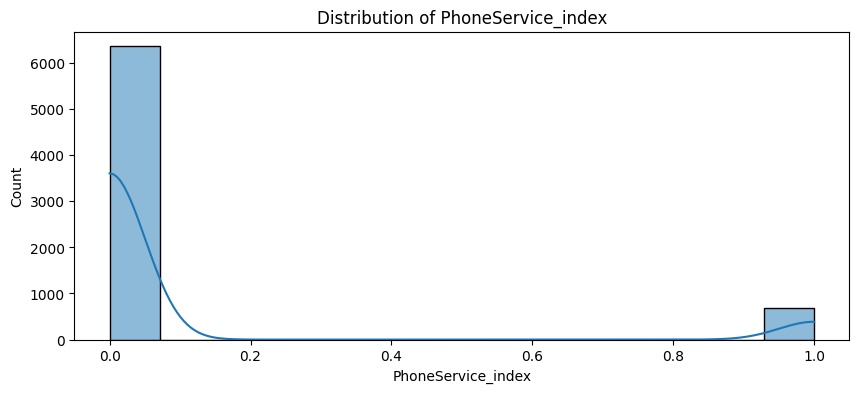

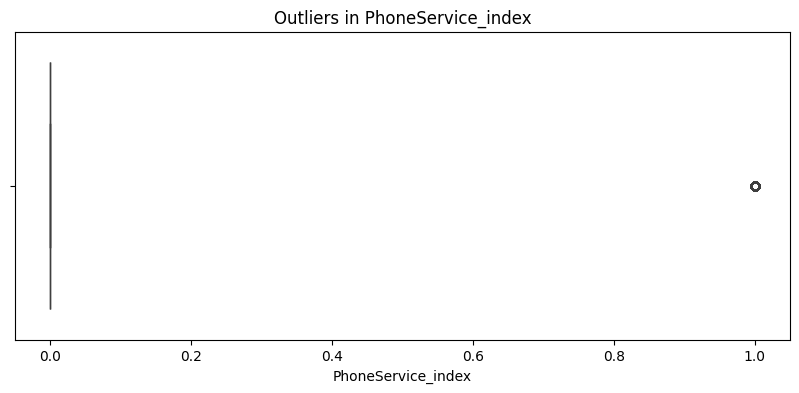

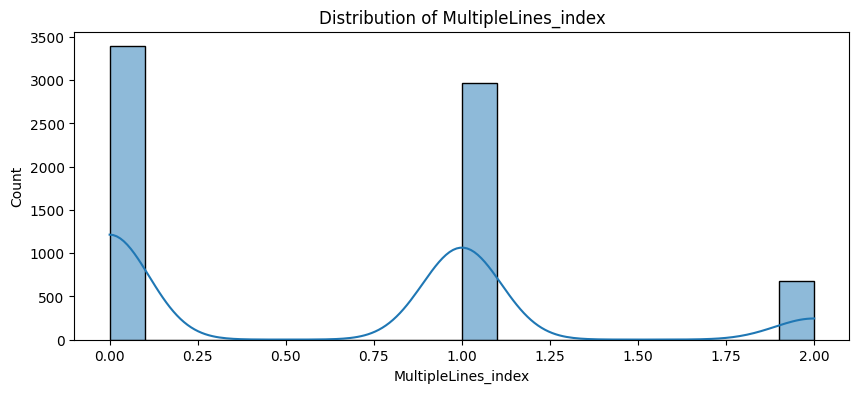

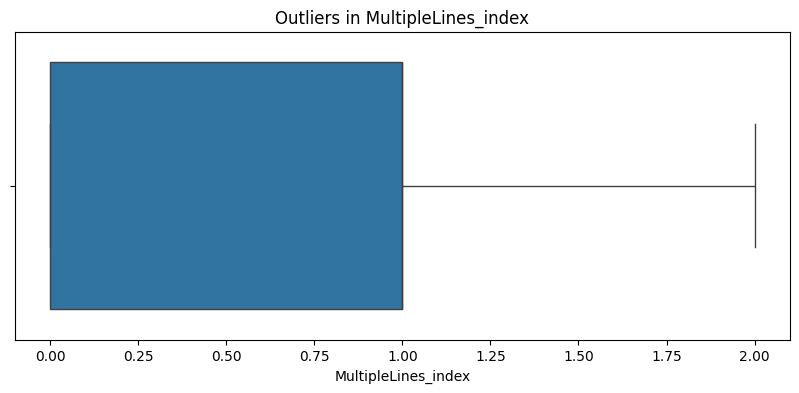

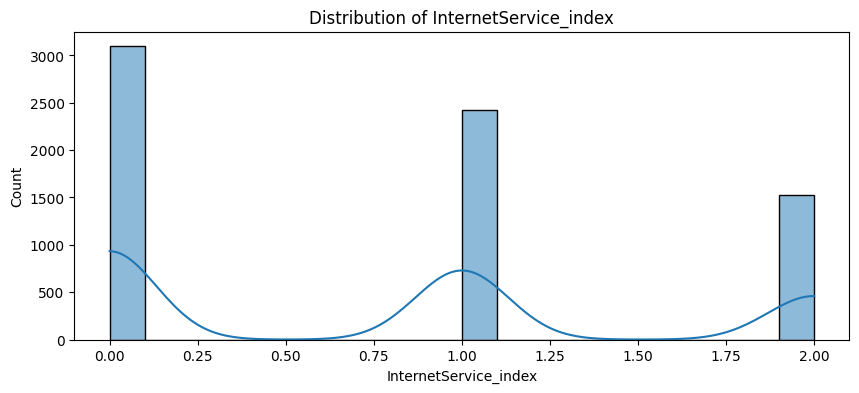

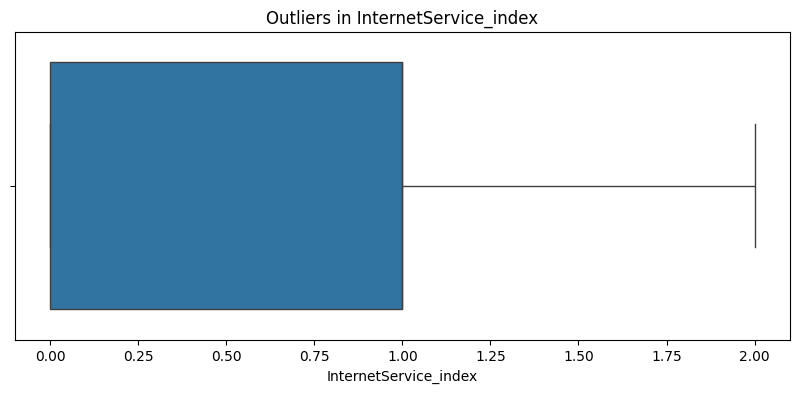

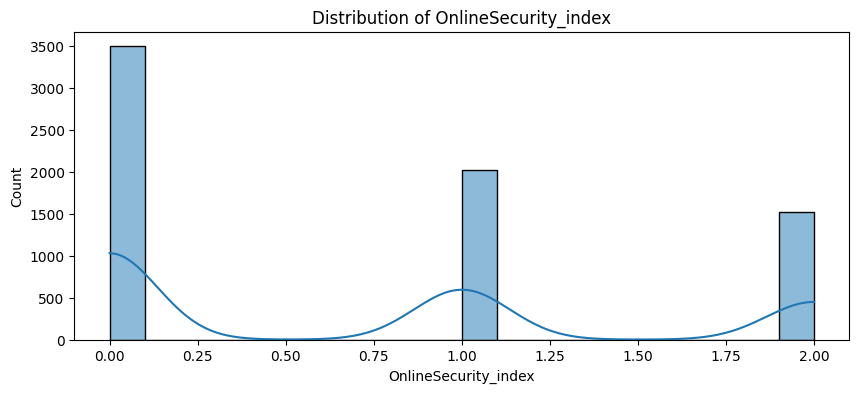

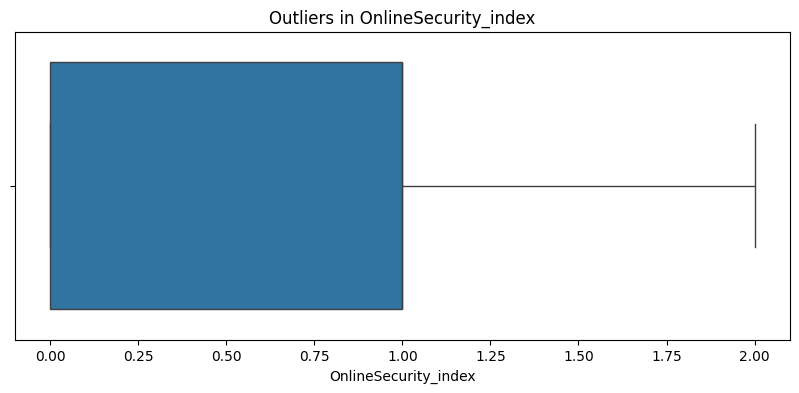

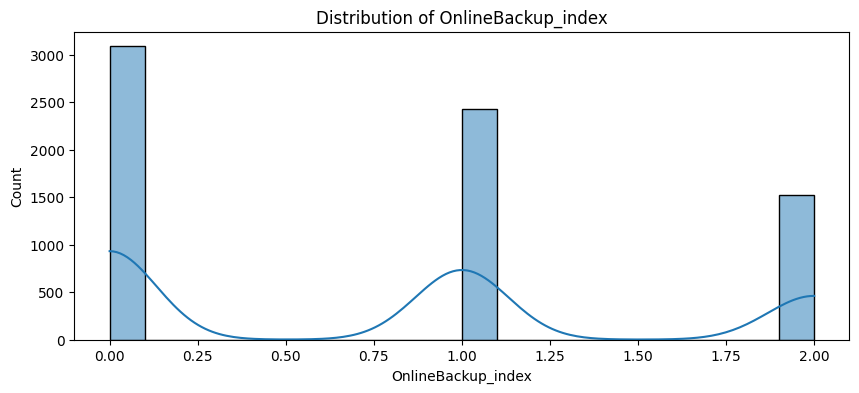

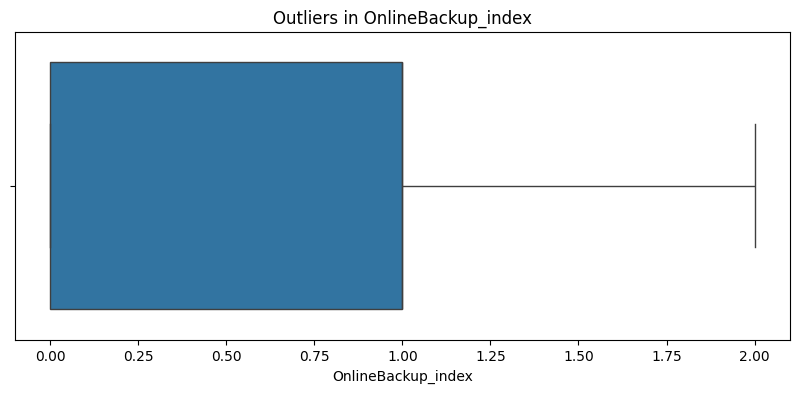

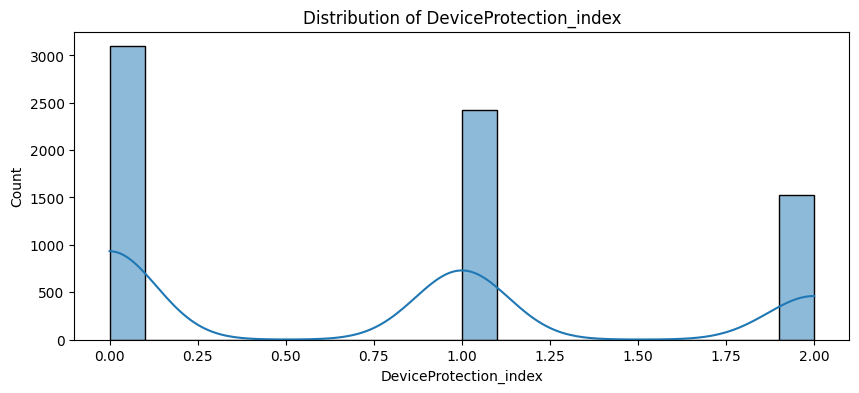

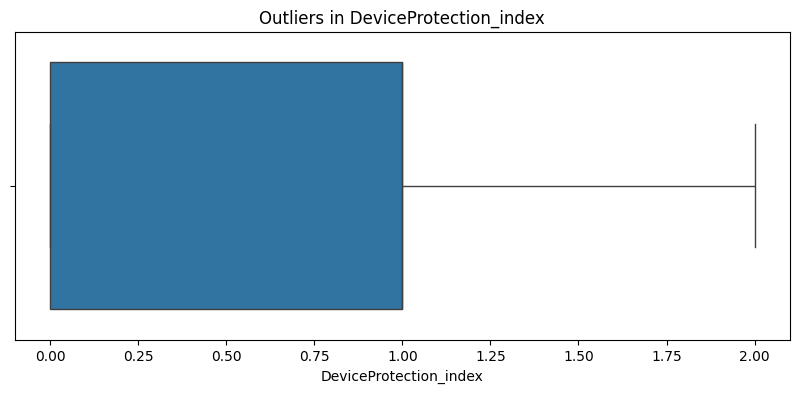

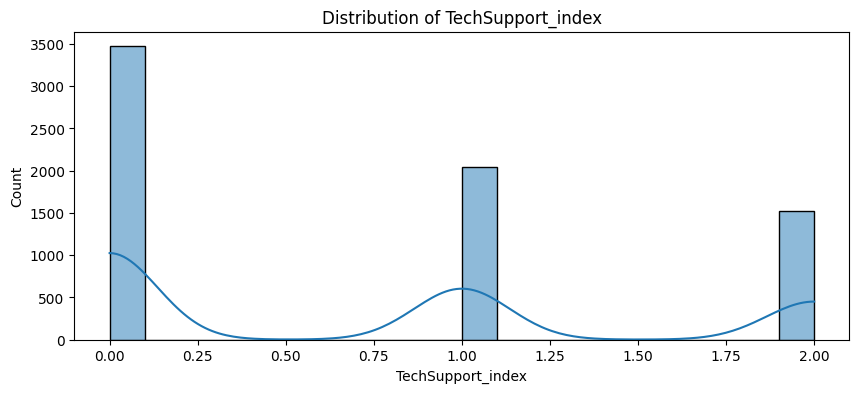

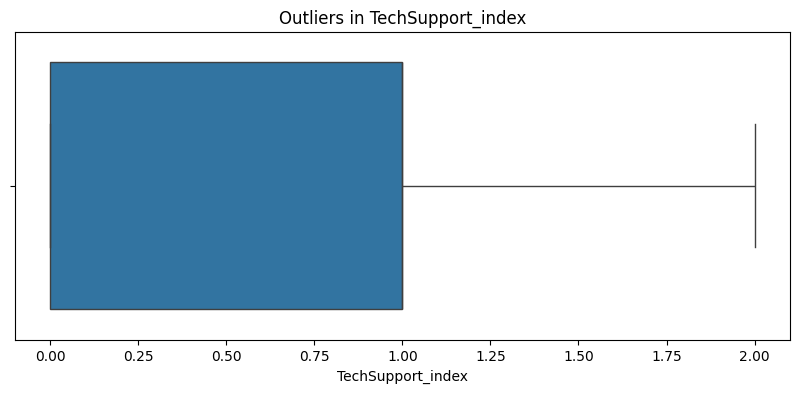

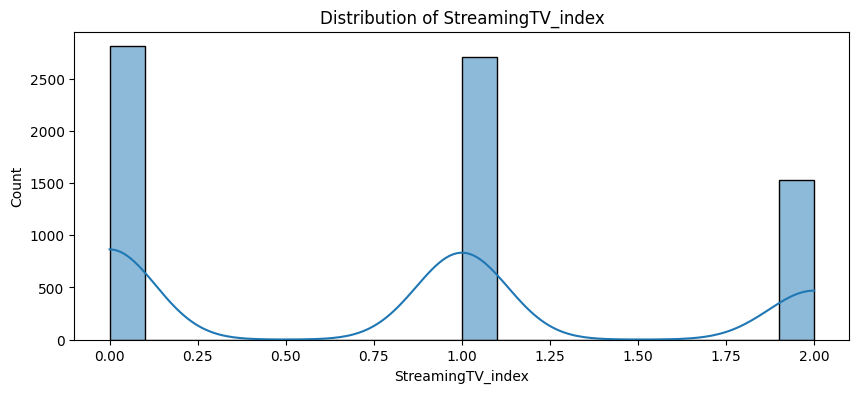

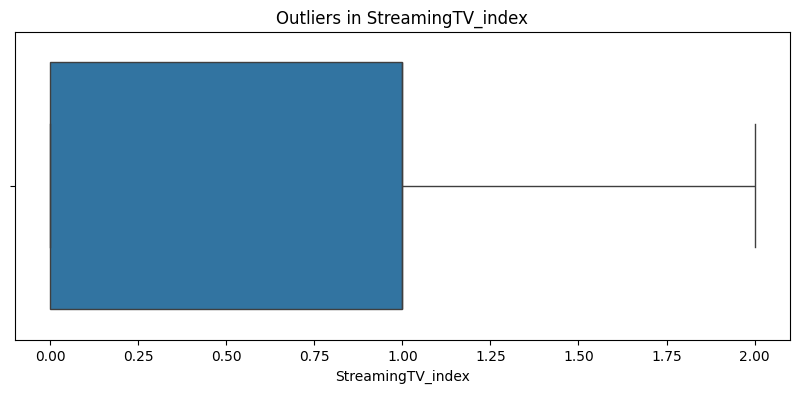

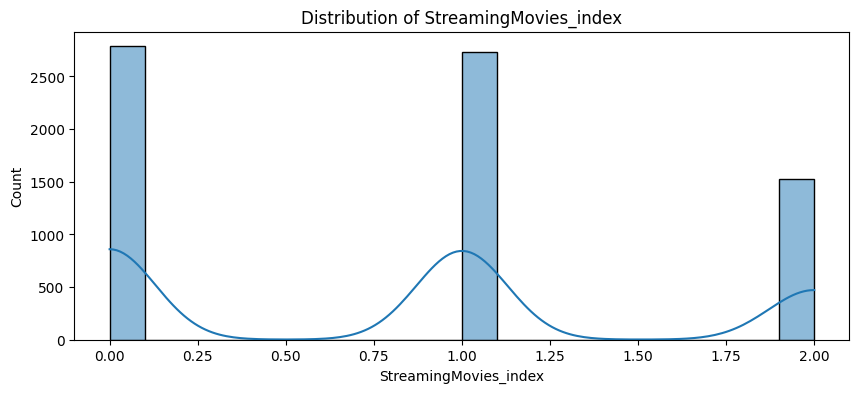

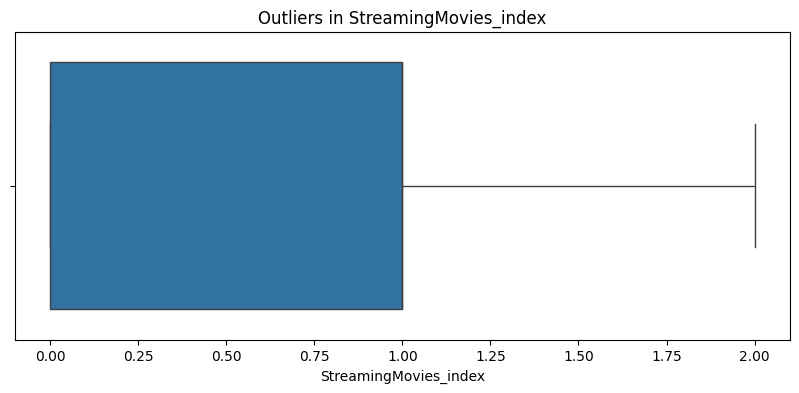

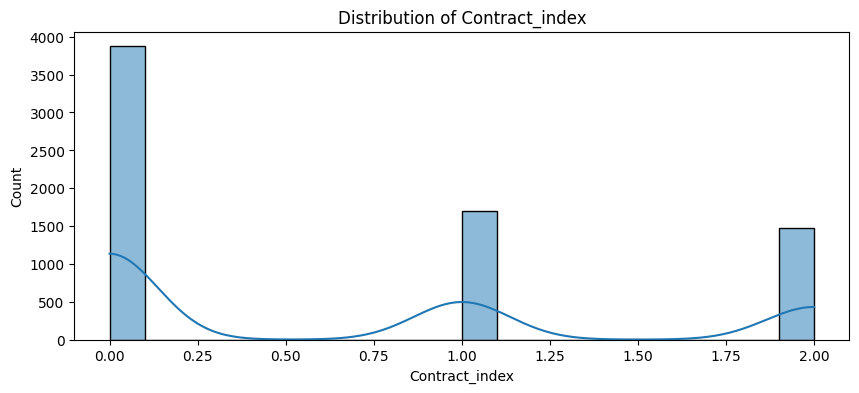

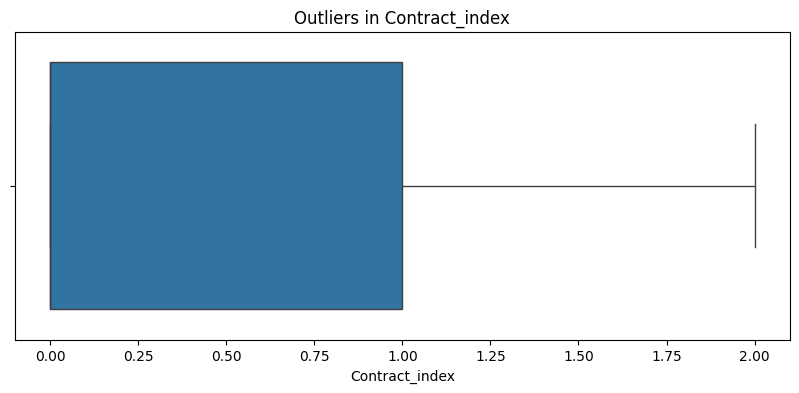

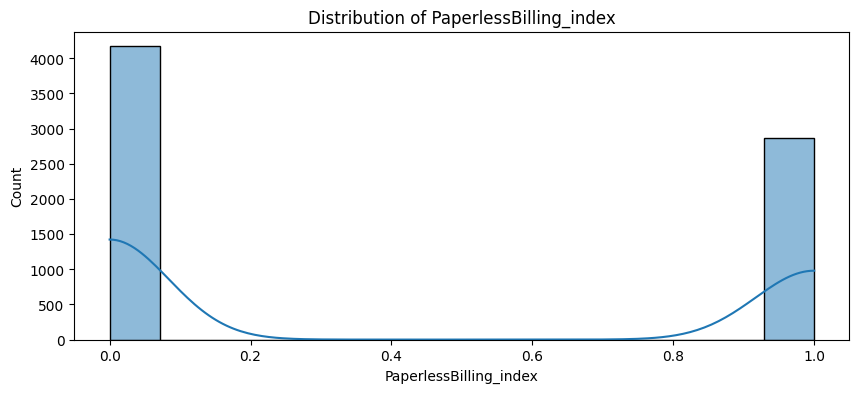

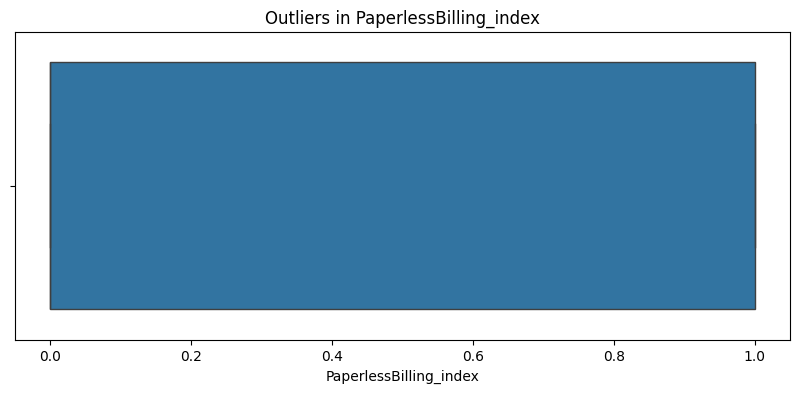

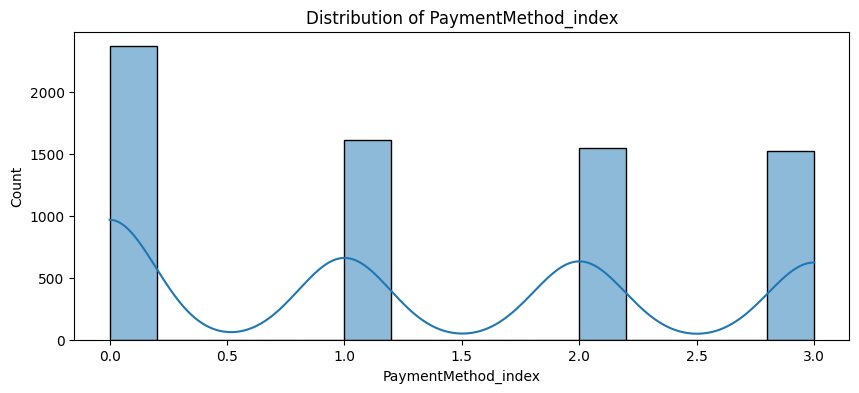

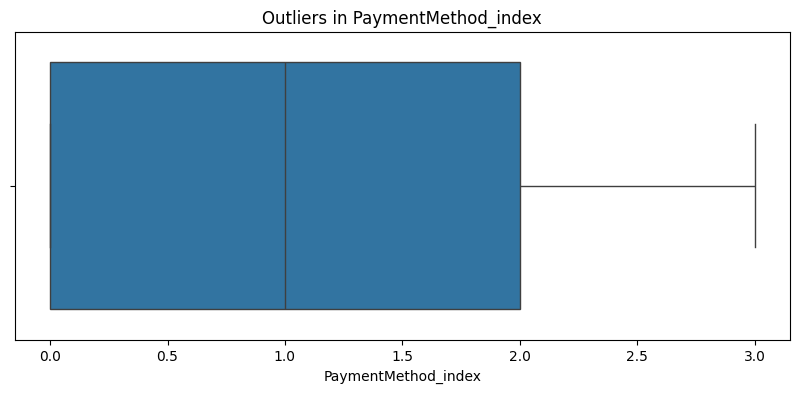

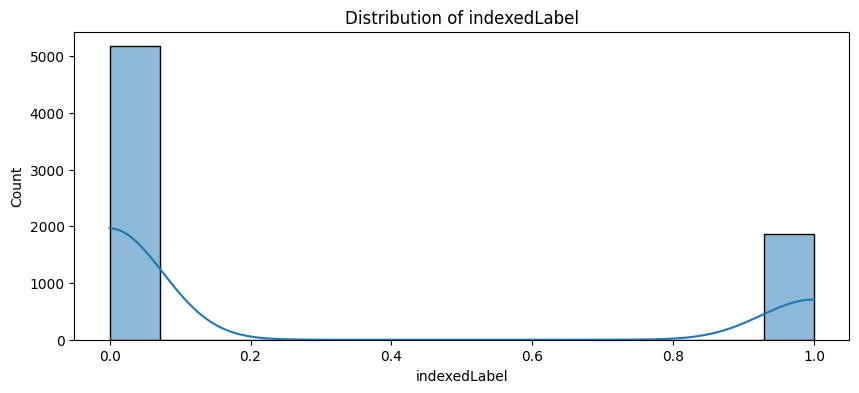

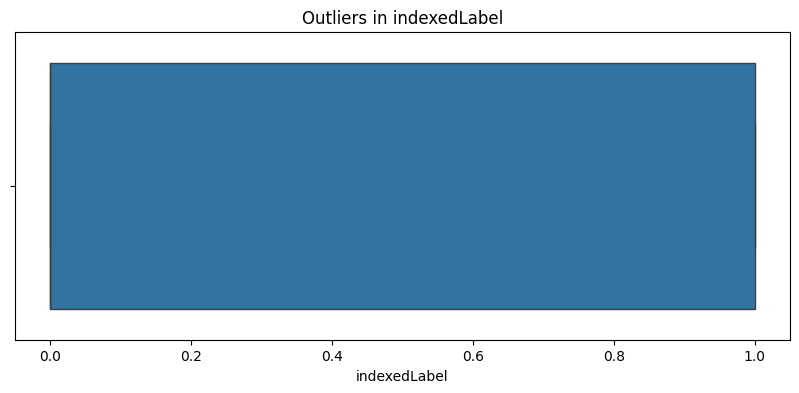

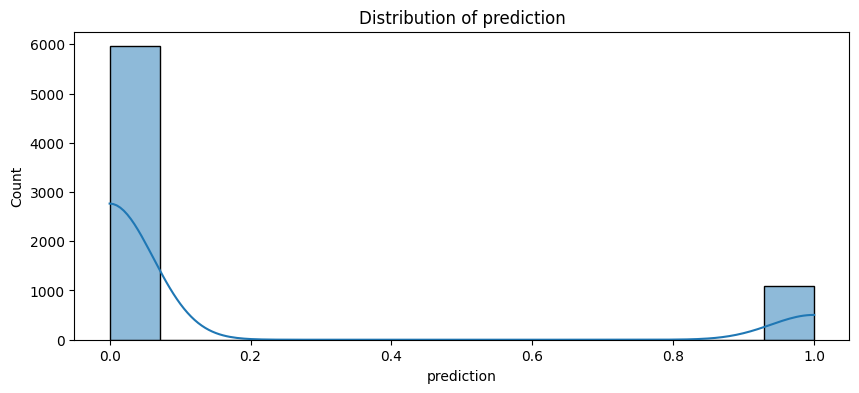

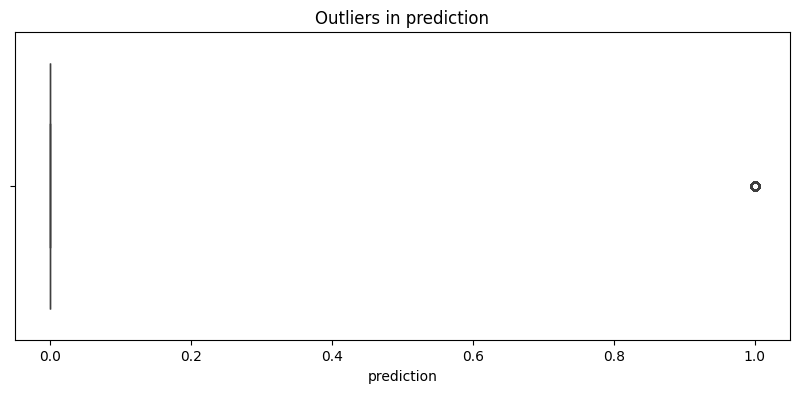

In [ ]:
# Histograms for all numerical features
numerical_features = pdf_transformed.select_dtypes(include=['float64', 'int64']).columns
for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(pdf_transformed[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

    # Boxplot for outliers
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=pdf_transformed[feature])
    plt.title(f'Outliers in {feature}')
    plt.show()


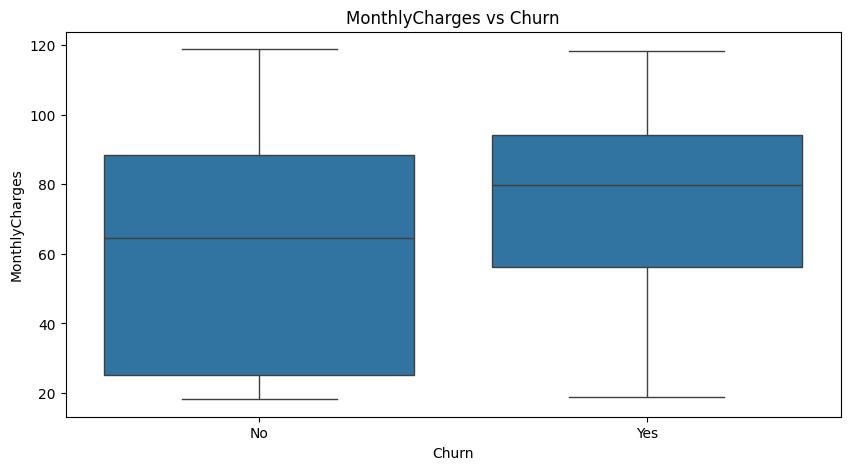

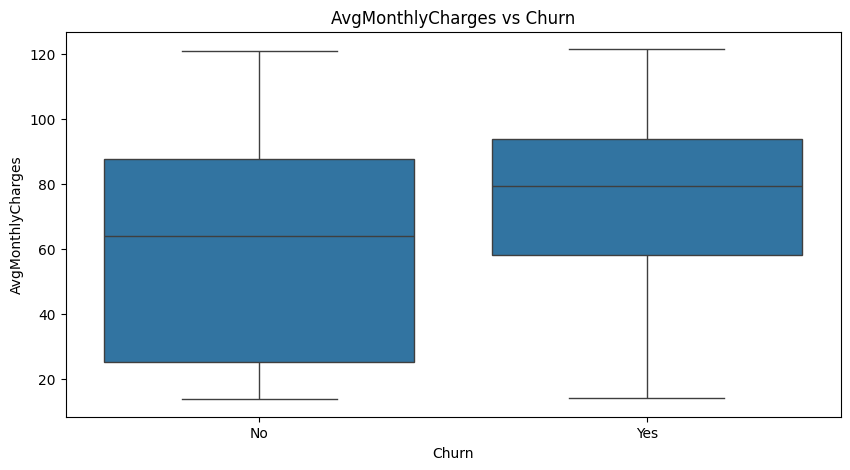

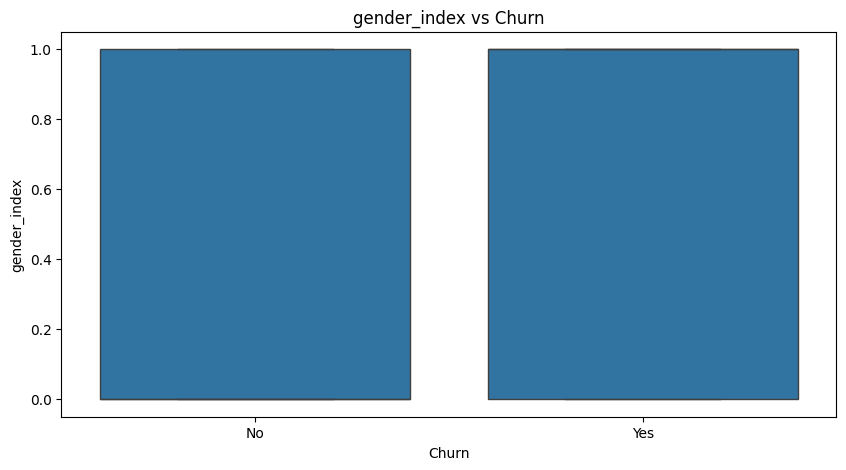

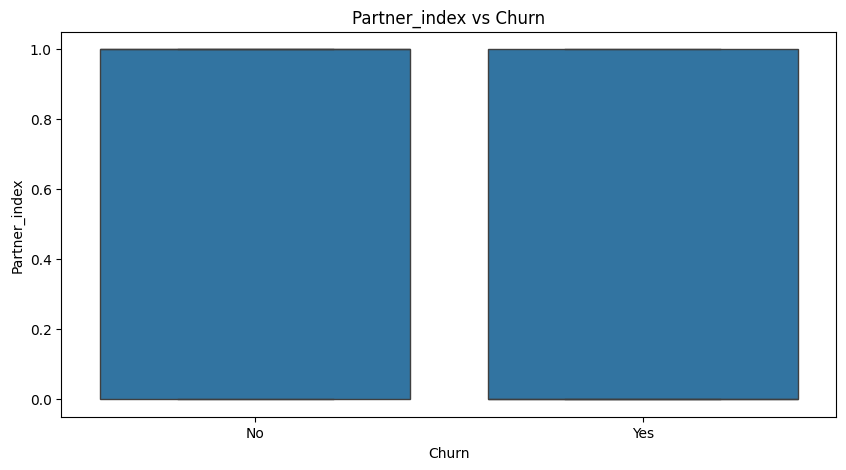

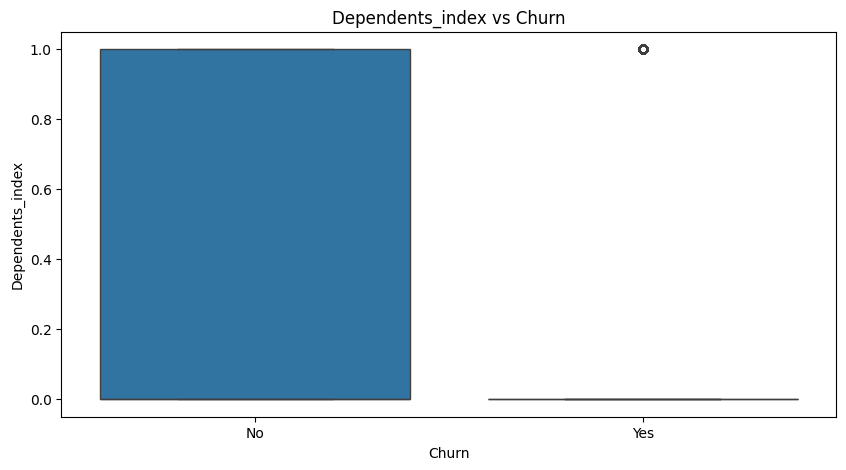

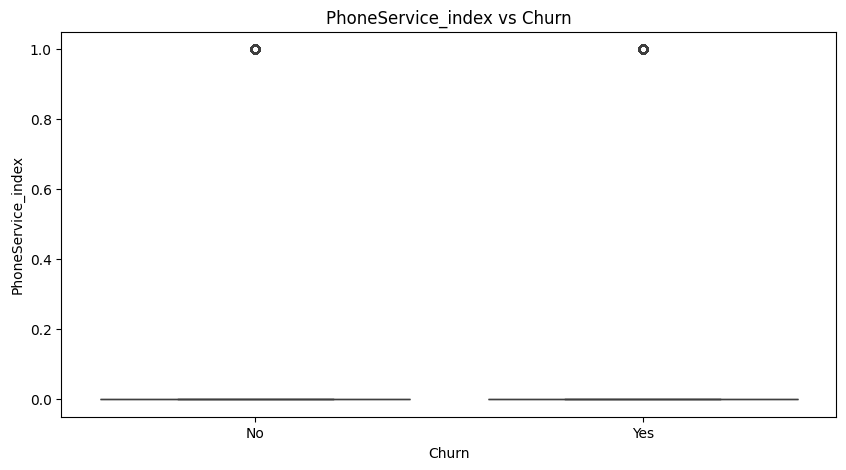

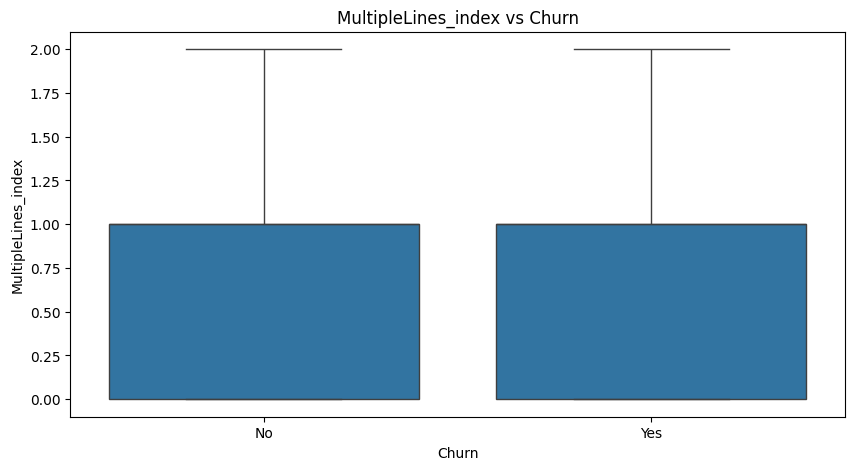

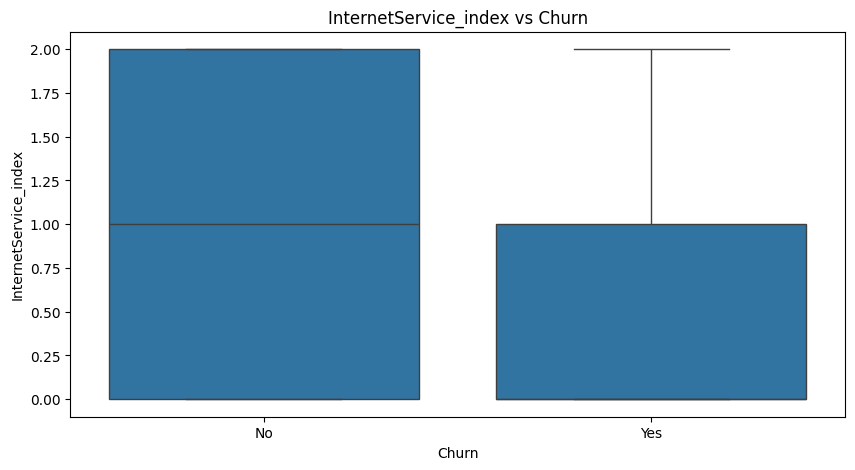

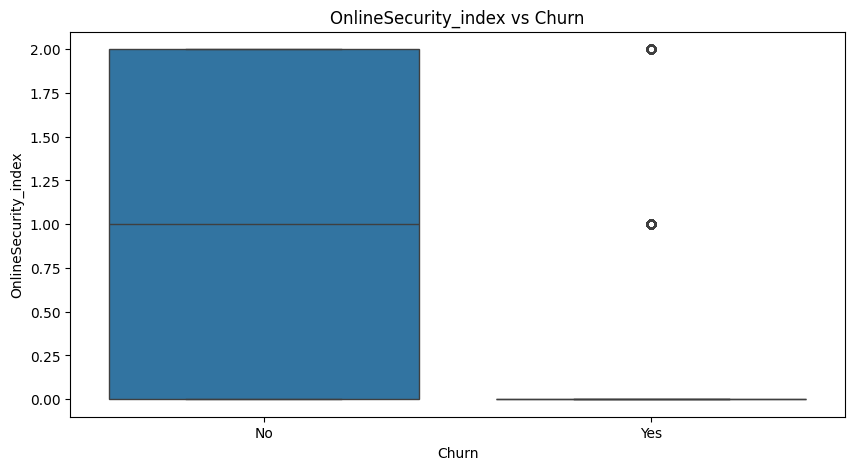

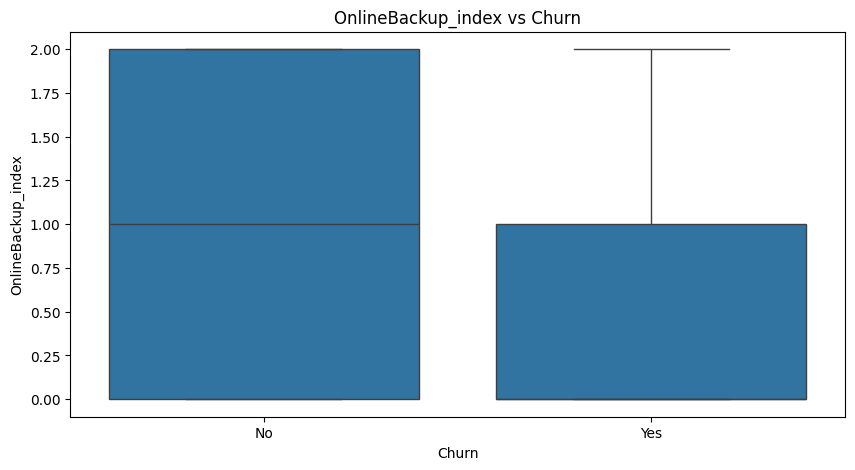

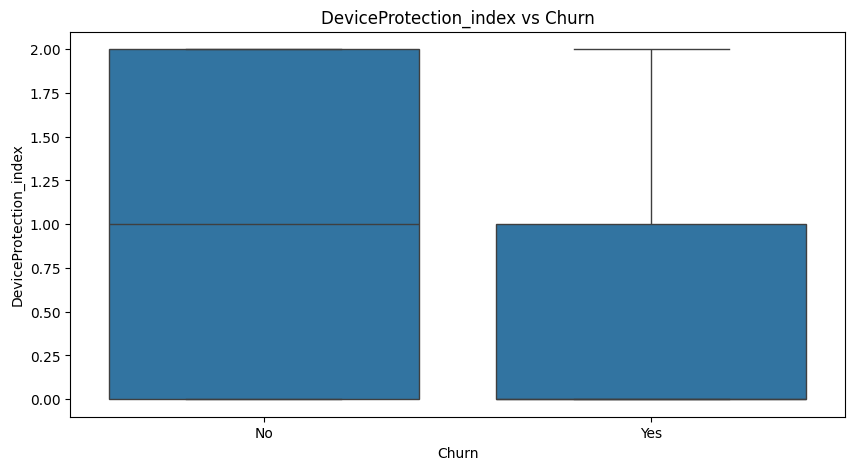

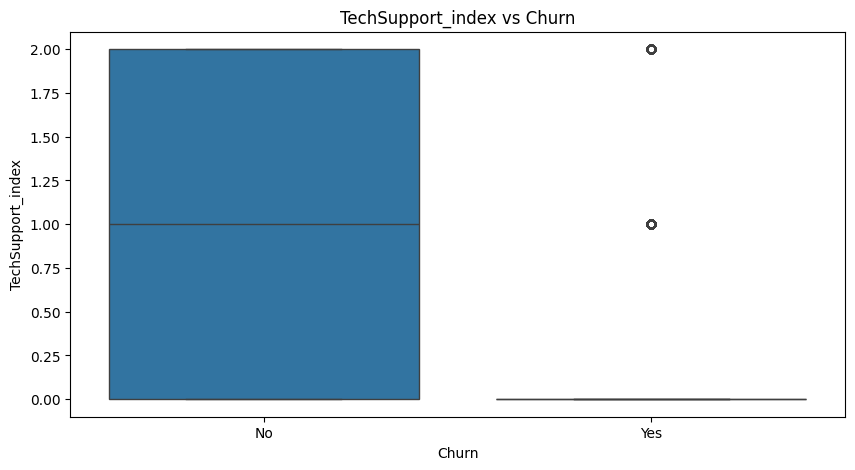

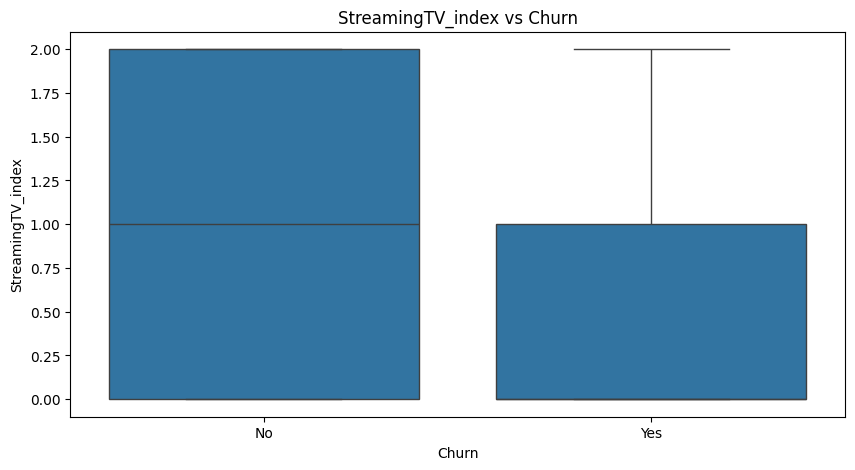

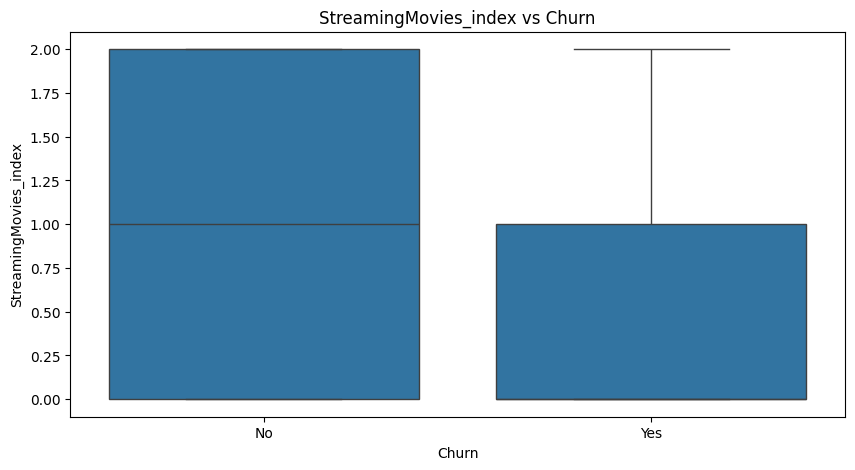

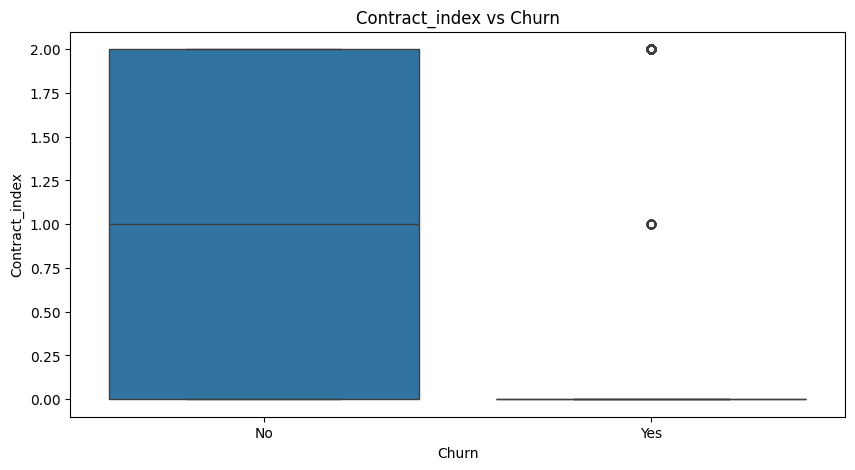

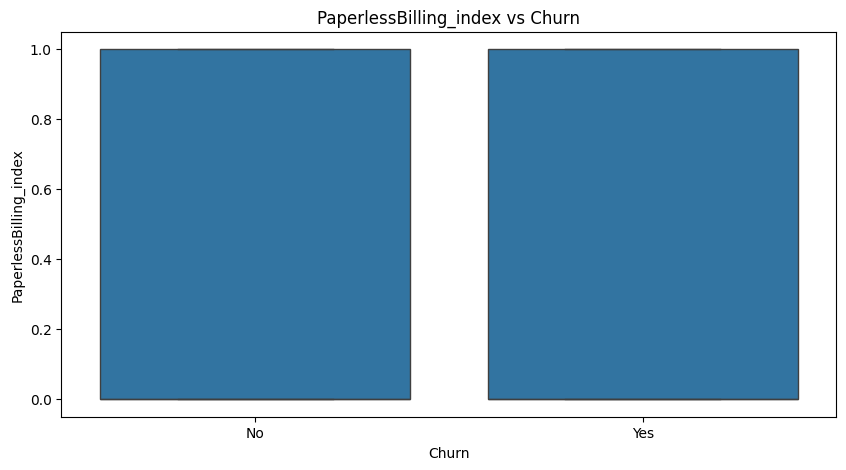

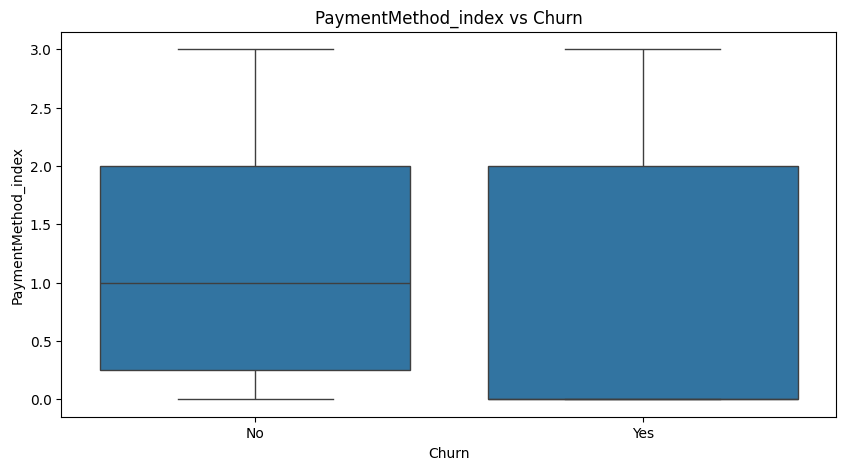

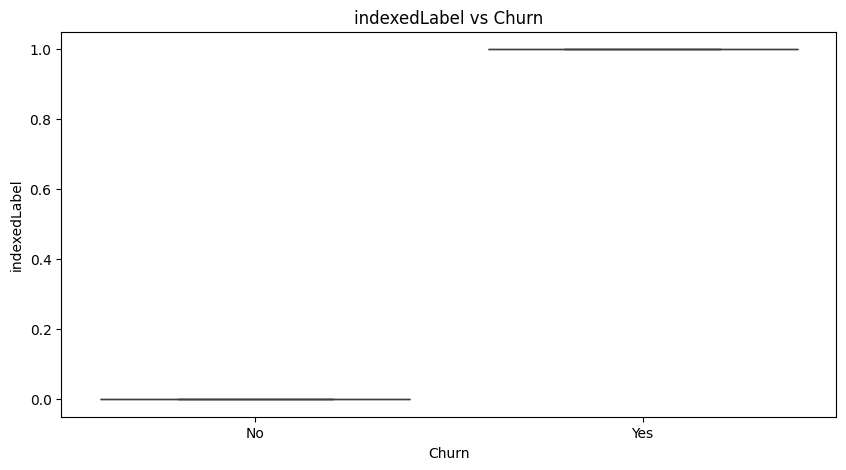

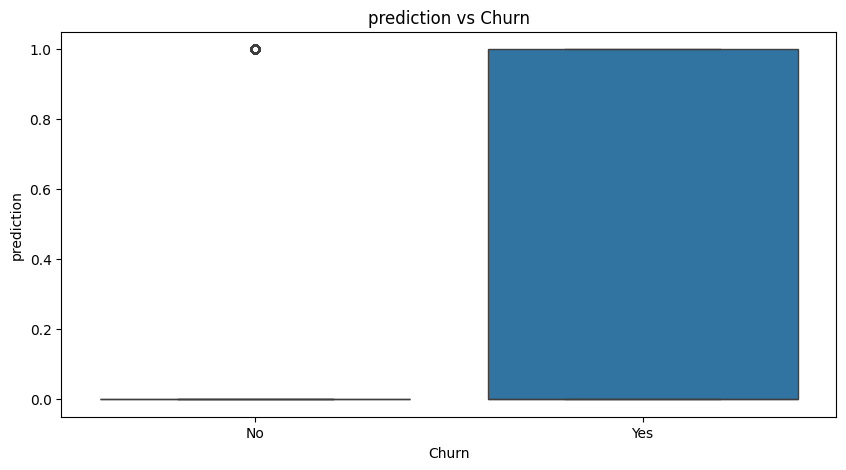

In [ ]:
# For categorical features, consider boxplots or bar charts against churn
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Churn', y=feature, data=pdf_transformed)
    plt.title(f'{feature} vs Churn')
    plt.show()


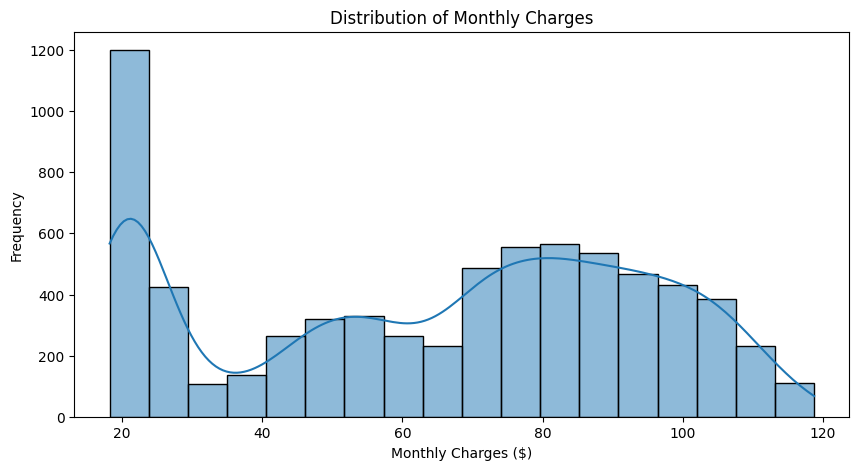

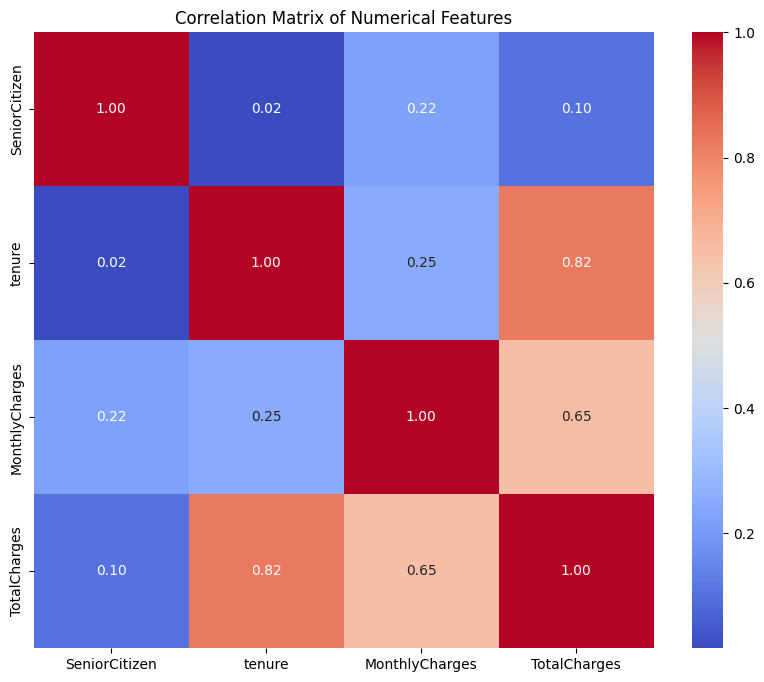

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for visualization
pdf = df.toPandas()

# Distribution of MonthlyCharges
plt.figure(figsize=(10, 5))
sns.histplot(pdf['MonthlyCharges'], kde=True)
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Frequency')
plt.show()

# Correlation Matrix
numerical_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(10, 8))
sns.heatmap(pdf[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [ ]:
# Print feature importances
for feat, imp in sorted_importances:
    print(f"Feature: {feat}, Importance: {imp}")


Feature: DeviceProtection_encoded, Importance: 0.1439603773601782
Feature: PaymentMethod_encoded, Importance: 0.11748554987277555
Feature: OnlineSecurity_encoded, Importance: 0.09024914317052174
Feature: Contract_encoded, Importance: 0.017501425883729712
Feature: StreamingTV_encoded, Importance: 0.01712062575160695
Feature: TechSupport_encoded, Importance: 0.016919057810189757
Feature: SeniorCitizen, Importance: 0.006361578375684286
Feature: StreamingMovies_encoded, Importance: 0.0061593026197163045
Feature: OnlineBackup_encoded, Importance: 0.004057942925690947
Feature: PaperlessBilling_encoded, Importance: 0.003656144858727653
Feature: Dependents_encoded, Importance: 0.0032010151855359245
Feature: TotalCharges, Importance: 0.0029974831015027736
Feature: MonthlyCharges, Importance: 0.002032208383850296
Feature: tenure, Importance: 0.0017557482547449284
Feature: Partner_encoded, Importance: 0.0006731830771976935
Feature: gender_encoded, Importance: 0.0005813690995928376
Feature: Intern

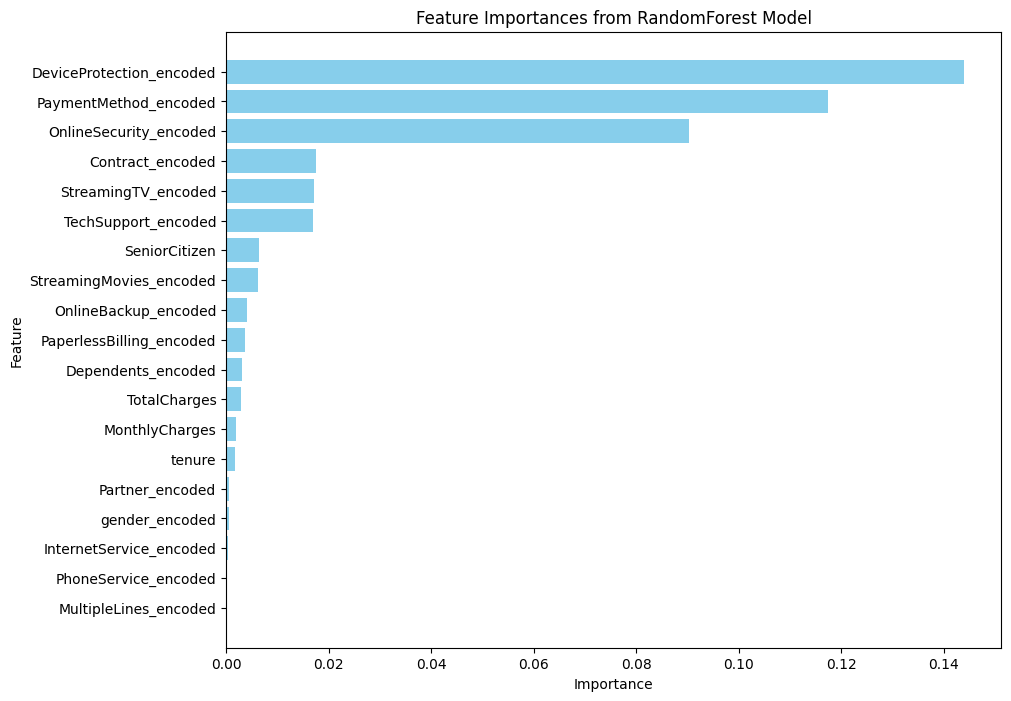

In [ ]:
# # Sorting features by importance for better visualization
# sorted_features = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
# sorted_features_names = [x[0] for x in sorted_features]
# sorted_importances = [x[1] for x in sorted_features]

# Extract features and their importances from sorted_importances
features, importances = zip(*sorted_importances)

# Create a horizontal bar plot for feature importances
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

**Model Development & Model Evaluation**

In [ ]:
# Split the data into training, validation, and test sets (60%, 20%, 20%)
(train_data, rest_data) = df.randomSplit([0.6, 0.4], seed=7)
(validation_data, test_data) = rest_data.randomSplit([0.4, 0.6], seed=7)


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create the RandomForest model and pipeline as previously defined
labelIndexer = StringIndexer(inputCol="Churn", outputCol="indexedLabel").fit(df)
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")
pipeline = Pipeline(stages=indexers + encoders + [labelIndexer, assembler, rf])

# Train the RandomForest model on the training data
model = pipeline.fit(train_data)

# Evaluate the model on the validation data
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", metricName="areaUnderROC")
validation_accuracy = evaluator.evaluate(model.transform(validation_data))
print("Validation AUC: ", validation_accuracy)

# Optionally, evaluate on the test set if desired
test_accuracy = evaluator.evaluate(model.transform(test_data))
print("Test AUC: ", test_accuracy)

# Extract the feature importances from the trained RandomForest model
rfModel = model.stages[-1]  # Assuming the RandomForest model is the last stage in the pipeline
feature_importances = rfModel.featureImportances

# Sort and print feature importances
importances_list = [(feature, importance) for feature, importance in zip(assemblerInputs, feature_importances)]
sorted_importances = sorted(importances_list, key=lambda x: x[1], reverse=True)
for feat, imp in sorted_importances:
    print(f"Feature: {feat}, Importance: {imp}")

# Transform the entire dataset using the trained model
df_transformed = model.transform(df)

# Show the transformed DataFrame
df_transformed.show()

# Optionally, convert to Pandas DataFrame for further analysis or visualization
pdf_transformed = df_transformed.toPandas()


Validation AUC:  0.8333571145461746
Test AUC:  0.8291198765577505
Feature: DeviceProtection_encoded, Importance: 0.1439603773601782
Feature: PaymentMethod_encoded, Importance: 0.11748554987277555
Feature: OnlineSecurity_encoded, Importance: 0.09024914317052174
Feature: Contract_encoded, Importance: 0.017501425883729712
Feature: StreamingTV_encoded, Importance: 0.01712062575160695
Feature: TechSupport_encoded, Importance: 0.016919057810189757
Feature: SeniorCitizen, Importance: 0.006361578375684286
Feature: StreamingMovies_encoded, Importance: 0.0061593026197163045
Feature: OnlineBackup_encoded, Importance: 0.004057942925690947
Feature: PaperlessBilling_encoded, Importance: 0.003656144858727653
Feature: Dependents_encoded, Importance: 0.0032010151855359245
Feature: TotalCharges, Importance: 0.0029974831015027736
Feature: MonthlyCharges, Importance: 0.002032208383850296
Feature: tenure, Importance: 0.0017557482547449284
Feature: Partner_encoded, Importance: 0.0006731830771976935
Feature:

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=indexers + encoders + [labelIndexer, assembler, rf])



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col


# Index the label column
labelIndexer = StringIndexer(inputCol="Churn", outputCol="label").fit(df)

# Set up the RandomForest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")


# Setup the pipeline and grid parameters
pipeline = Pipeline(stages=indexers + encoders + [labelIndexer, assembler, rf])
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5,10,30, 50]) \
    .addGrid(rf.maxDepth, [5, 15, 30]) \
    .addGrid(rf.maxBins, [8,16, 32]) \
    .addGrid(rf.minInstancesPerNode, [1, 4,10]) \
    .build()

# Setup the CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC"),
                          numFolds=5)

# Fit the model using CrossValidator
cvModel = crossval.fit(train_data)



In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Generate predictions on the training and validation datasets
train_predictions = cvModel.bestModel.transform(train_data)
validation_predictions = cvModel.bestModel.transform(validation_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
train_auc = evaluator.evaluate(train_predictions)
validation_auc = evaluator.evaluate(validation_predictions)

# Print AUC metrics
print(f"Train AUC: {train_auc}")
print(f"Validation AUC: {validation_auc}")

# Confusion Matrix and Classification Metrics
def get_confusion_matrix(predictions):
    # Convert DataFrame to RDD
    predictionAndLabels = predictions.select(['prediction', 'label']).rdd
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    # Confusion matrix
    print("Confusion Matrix:")
    print(metrics.confusionMatrix().toArray())

# Get confusion matrix for validation predictions
get_confusion_matrix(validation_predictions)

# Additional classification metrics
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")

validation_accuracy = accuracy_evaluator.evaluate(validation_predictions)
validation_precision = precision_evaluator.evaluate(validation_predictions)
validation_recall = recall_evaluator.evaluate(validation_predictions)
validation_f1 = f1_evaluator.evaluate(validation_predictions)

# Print classification report
print(f"Validation Accuracy: {validation_accuracy}")
print(f"Validation Precision: {validation_precision}")
print(f"Validation Recall: {validation_recall}")
print(f"Validation F1 Score: {validation_f1}")


Train AUC: 0.8926591390927925
Validation AUC: 0.837748711850972


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[774.  67.]
 [157. 143.]]
Validation Accuracy: 0.803680981595092
Validation Precision: 0.7918167774513284
Validation Recall: 0.803680981595092
Validation F1 Score: 0.7913442433850106


In [ ]:
# Evaluating the model on validation data
predictions_validation = cvModel.transform(validation_data)
predictions_test = cvModel.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

roc_auc_validation = evaluator.evaluate(predictions_validation)
roc_auc_test = evaluator.evaluate(predictions_test)

print(f"Validation ROC-AUC: {roc_auc_validation}")
print(f"Test ROC-AUC: {roc_auc_test}")


Validation ROC-AUC: 0.837748711850972
Test ROC-AUC: 0.8331984890613993


In [ ]:
# Additional metrics
f1Evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
precisionEvaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
recallEvaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

f1_score = f1Evaluator.evaluate(predictions_test)
precision = precisionEvaluator.evaluate(predictions_test)
recall = recallEvaluator.evaluate(predictions_test)

print(f"Test F1 Score: {f1_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")


Test F1 Score: 0.7731173026448617
Test Precision: 0.7735511718455224
Test Recall: 0.7846153846153846


In [ ]:
from pyspark.ml import PipelineModel

# Save the trained model
cvModel.bestModel.write().overwrite().save("/content/model/")

# To load the model in a production environment
loaded_model = PipelineModel.load("/content/model/")


**Deployment Using Flask**

In [ ]:
import shutil
import os

# Define the directory path and the output zip file name
directory_path = '/content/model'
output_filename = '/content/model_archive'

# Create a zip file (without compression, as an example)
shutil.make_archive(output_filename, 'zip', directory_path)

print(f"Directory {directory_path} is zipped into {output_filename}.zip")


Directory /content/model is zipped into /content/model_archive.zip


In [ ]:
from flask import Flask, request, jsonify
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel

# Initialize Flask app
app = Flask(__name__)

# Load PySpark model
def load_model():
    spark = SparkSession.builder \
        .appName("Churn Prediction Service") \
        .getOrCreate()
    model = PipelineModel.load("/content/model/")
    return spark, model

spark, model = load_model()

# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from POST request
        data = request.get_json()
        # Assume data is in JSON format and matches the model's feature schema
        df = spark.createDataFrame([data])
        # Make prediction
        result = model.transform(df)
        # Extract prediction result
        prediction = result.select("prediction").collect()[0]["prediction"]
        return jsonify({'prediction': str(prediction)})
    except Exception as e:
        return jsonify({'error': str(e)})

# Run the Flask application
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
!unzip model_archive.zip

Archive:  model_archive.zip
   creating: metadata/
   creating: stages/
   creating: stages/00_StringIndexer_1e3e230f3a6e/
   creating: stages/01_StringIndexer_f4994ea2f91a/
   creating: stages/02_StringIndexer_c3e09209ecb7/
   creating: stages/03_StringIndexer_db4afb93edd2/
   creating: stages/04_StringIndexer_30549c8eb376/
   creating: stages/05_StringIndexer_9bae9ed08eca/
   creating: stages/06_StringIndexer_c0dd7646f05f/
   creating: stages/07_StringIndexer_0b255ac70675/
   creating: stages/08_StringIndexer_4f1662607c85/
   creating: stages/09_StringIndexer_df834b924a29/
   creating: stages/10_StringIndexer_a2598297cab4/
   creating: stages/11_StringIndexer_4f2ebe9ff6bb/
   creating: stages/12_StringIndexer_52aa15c7a53c/
   creating: stages/13_StringIndexer_651cda33e2e0/
   creating: stages/14_StringIndexer_5fb2290fd343/
   creating: stages/15_OneHotEncoder_136f727c01cb/
   creating: stages/16_OneHotEncoder_8a798938a76c/
   creating: stages/17_OneHotEncoder_654d654d4fb7/
   creatin

In [ ]:
!mkdir model
